# Cart Pole Deep Q-Learning

## Miembros
- Andrés Montoya 21552
- Fernanda Esquivel 21542
- Francisco Castillo 21562
- Fabián Juárez 21440
- Diego Lemus 21469

## Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/FranzCastillo/DeepQ-CartPole)

# Task 1

## Libraries

In [1]:
# !pip install gymnasium
# !pip install numpy
# !pip install torch
# !pip install keras

In [32]:
import random as rand
from collections import deque
from dataclasses import dataclass

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.src.layers import BatchNormalization, Dropout
from keras.regularizers import l2
import tensorflow as tf
from keras.losses import Huber

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


I0000 00:00:1727647926.004572    6664 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727647926.640537    6664 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727647926.640583    6664 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Memory Implementation

In [4]:
class Memory:
    """
    Experience Replay Memory.
    
    Args:
        max_memory (int): Maximum number of experiences the Memory can keep.
    """

    def __init__(self, max_memory):
        self._samples = deque(maxlen=max_memory)

    def add_sample(self, sample):
        self._samples.append(sample)

    def sample(self, num_samples):
        num_samples = min(num_samples, len(self._samples))
        return rand.sample(self._samples, num_samples)

    @property
    def num_samples(self):
        return len(self._samples)

### DEEP Q-LEARNING AGENT

In [5]:
class DQLAgent:
    """
    Deep Q-Learning Agent.
    """

    def __init__(self, state_size, action_size, hyperparameters, architecture):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = Memory(max_memory=10000)
        self.gamma = hyperparameters.gamma
        self.epsilon = hyperparameters.epsilon
        self.epsilon_min = hyperparameters.epsilon_min
        self.epsilon_decay = hyperparameters.epsilon_decay
        self.learning_rate = hyperparameters.learning_rate
        self.batch_size = hyperparameters.batch_size
        self.main_model = architecture(learning_rate=self.learning_rate)
        self.target_model = architecture(learning_rate=self.learning_rate)
        self.update_target_model()

    def update_target_model(self):
        """
        Updates the target Q-network with the weights of the main Q-network.
        """
        self.target_model.set_weights(self.main_model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Stores an experience in the replay memory.
        """
        self.memory.add_sample((state, action, reward, next_state, done))

    def act(self, state):
        """
        Selects an action using the epsilon-greedy policy.
        
        Args:
            state (array): Current state.
            
        Returns:
            int: Selected action.
        """
        if np.random.rand() <= self.epsilon:
            return rand.randrange(self.action_size)
        q_values = self.main_model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        """
        Trains the Q-network using a batch of experiences from the replay memory.
        """
        if self.memory.num_samples < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states = np.array([sample[0] for sample in batch])
        actions = np.array([sample[1] for sample in batch])
        rewards = np.array([sample[2] for sample in batch])
        next_states = np.array([sample[3] for sample in batch])
        dones = np.array([sample[4] for sample in batch])

        # Target Q-values prediction
        next_qs = self.target_model.predict(next_states, verbose=0)
        max_next_qs = np.max(next_qs, axis=1)
        target_qs = rewards + (1 - dones) * self.gamma * max_next_qs

        # Actual Q-values prediction
        current_qs = self.main_model.predict(states, verbose=0)
        for i, action in enumerate(actions):
            current_qs[i][action] = target_qs[i]

        # Q-network training
        self.main_model.fit(states, current_qs, epochs=1, verbose=0)

    def load(self, name):
        """
        Loads a model from a file.
        
        Args:
            name (str): Name of the file.
        """
        self.main_model = load_model(name, custom_objects={'mse': MeanSquaredError()})
        self.target_model = load_model(name, custom_objects={'mse': MeanSquaredError()})

    def save(self, name):
        """
        Saves the model to a file.
        
        Args:
            name (str): Name of the file.
        """
        self.main_model.save(name)

In [6]:
def train_agent(env, agent, n_episodes, max_iterations, target_update_frequency):
    """
    Trains the agent using Deep Q-Learning.
    
    Args:
        env (gym.Env): Environment.
        agent (DQLAgent): Agent.
        
    Returns:
        DQLAgent: Trained agent.
    """
    episode_rewards = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0

        for t in range(max_iterations):
            # Action selection
            action = agent.act(state)

            # Environment interaction
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward

            # Store experience in replay memory
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            # Experience replay
            agent.replay()

            if done or truncated:
                print(
                    f"Episodio {episode + 1}/{n_episodes}, Recompensa Total: {total_reward}, Epsilon: {agent.epsilon:.2f}")
                break

        episode_rewards.append(total_reward)

        # Target model update
        if (episode + 1) % target_update_frequency == 0:
            agent.update_target_model()

        # Exploration rate decay
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay

    env.close()

    # Graph total rewards per episode
    plt.plot(range(1, n_episodes + 1), episode_rewards, marker='o')
    plt.title('Recompensa Total por Episodio')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa Total')
    y_max = max(episode_rewards) * 1.1
    plt.ylim(0, y_max)
    plt.show()

In [7]:
def test_agent(env, agent, episodes=5):
    """
    Tests the agent in the environment.
    
    Args:
        env (gym.Env): Environment.
        agent (DQLAgent): Agent.
        episodes (int): Number of episodes to run.
    """
    total_rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            q_values = agent.main_model.predict(np.array([state]), verbose=0)
            action = np.argmax(q_values[0])
            state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            if done or truncated:
                total_rewards.append(total_reward)
                print(f"Prueba Episodio {episode + 1}/{episodes}, Recompensa Total: {total_reward}")
                break
    avg_reward = np.mean(total_rewards)
    print(f"Recompensa promedio en {episodes} pruebas: {avg_reward}")
    env.close()

In [8]:
@dataclass
class Hyperparameters:
    """
    Hyperparameters for the Deep Q-Learning agent.
    
    Args:
        gamma (float): Discount factor.
        epsilon (float): Initial exploration rate.
        epsilon_min (float): Minimum exploration rate.
        epsilon_decay (float): Exploration decay rate per episode.
        learning_rate (float): Learning rate.
        batch_size (int): Number of experiences to sample per training step.
    """
    gamma: float
    epsilon: float
    epsilon_min: float
    epsilon_decay: float
    learning_rate: float
    batch_size: int

In [9]:
# Set the hyperparameters through a dataclass
hyperparameters1 = Hyperparameters(
    gamma=0.95,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    learning_rate=0.001,
    batch_size=64
)

In [10]:
hyperparameters2 = Hyperparameters(
    gamma=0.95,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.99,
    learning_rate=0.002,
    batch_size=32
)

In [11]:
def model1(learning_rate):
    model = Sequential()
    model.add(Dense(24, input_dim=state_size, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

In [33]:
def model2(learning_rate):
    model = Sequential([
        Dense(64, input_dim=state_size, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dense(action_size, activation='linear')
    ])
    model.compile(loss=Huber(), optimizer=Adam(learning_rate=learning_rate))
    return model

## Model 1

In [13]:
env = gym.make("CartPole-v1", render_mode=None)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [14]:
agent = DQLAgent(state_size, action_size, hyperparameters1, model1)

/usr/local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1727647926.894948    6664 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727647926.895038    6664 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727647926.895133    6664 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727647927.752313    6664 cuda_executor.cc:1001] could not open

Episodio 1/150, Recompensa Total: 11.0, Epsilon: 1.00
Episodio 2/150, Recompensa Total: 24.0, Epsilon: 0.99


I0000 00:00:1727647929.062660    6721 service.cc:146] XLA service 0x7f955c004eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727647929.062802    6721 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-09-29 22:12:09.094434: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-29 22:12:09.206125: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1727647929.290200    6721 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episodio 3/150, Recompensa Total: 16.0, Epsilon: 0.99
Episodio 4/150, Recompensa Total: 19.0, Epsilon: 0.99
Episodio 5/150, Recompensa Total: 15.0, Epsilon: 0.98
Episodio 6/150, Recompensa Total: 41.0, Epsilon: 0.98
Episodio 7/150, Recompensa Total: 16.0, Epsilon: 0.97
Episodio 8/150, Recompensa Total: 14.0, Epsilon: 0.97
Episodio 9/150, Recompensa Total: 18.0, Epsilon: 0.96
Episodio 10/150, Recompensa Total: 40.0, Epsilon: 0.96
Episodio 11/150, Recompensa Total: 43.0, Epsilon: 0.95
Episodio 12/150, Recompensa Total: 17.0, Epsilon: 0.95
Episodio 13/150, Recompensa Total: 12.0, Epsilon: 0.94
Episodio 14/150, Recompensa Total: 19.0, Epsilon: 0.94
Episodio 15/150, Recompensa Total: 35.0, Epsilon: 0.93
Episodio 16/150, Recompensa Total: 15.0, Epsilon: 0.93
Episodio 17/150, Recompensa Total: 42.0, Epsilon: 0.92
Episodio 18/150, Recompensa Total: 11.0, Epsilon: 0.92
Episodio 19/150, Recompensa Total: 18.0, Epsilon: 0.91
Episodio 20/150, Recompensa Total: 14.0, Epsilon: 0.91
Episodio 21/150, 

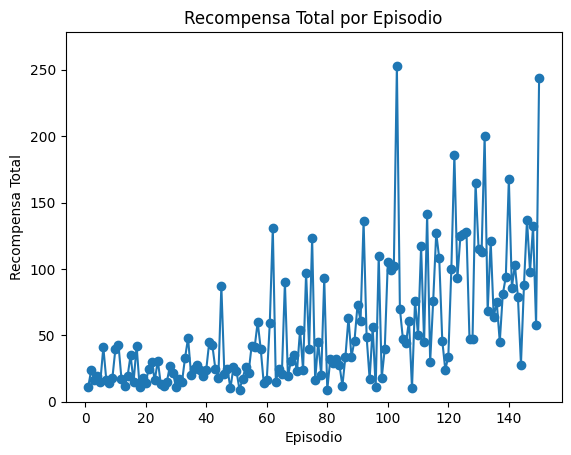

In [15]:
train_agent(env, agent, n_episodes=150, max_iterations=500, target_update_frequency=10)

In [16]:
agent.save("model1.keras")

In [17]:
test_agent(env, agent, episodes=5)

Prueba Episodio 1/5, Recompensa Total: 127.0
Prueba Episodio 2/5, Recompensa Total: 134.0
Prueba Episodio 3/5, Recompensa Total: 134.0
Prueba Episodio 4/5, Recompensa Total: 131.0
Prueba Episodio 5/5, Recompensa Total: 128.0
Recompensa promedio en 5 pruebas: 130.8


## Model 2

In [34]:
env = gym.make("CartPole-v1", render_mode=None)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [39]:
agent = DQLAgent(state_size, action_size, hyperparameters2, model1)

Episodio 1/150, Recompensa Total: 21.0, Epsilon: 1.00
Episodio 2/150, Recompensa Total: 10.0, Epsilon: 0.99
Episodio 3/150, Recompensa Total: 12.0, Epsilon: 0.98
Episodio 4/150, Recompensa Total: 25.0, Epsilon: 0.97
Episodio 5/150, Recompensa Total: 15.0, Epsilon: 0.96
Episodio 6/150, Recompensa Total: 18.0, Epsilon: 0.95
Episodio 7/150, Recompensa Total: 13.0, Epsilon: 0.94
Episodio 8/150, Recompensa Total: 11.0, Epsilon: 0.93
Episodio 9/150, Recompensa Total: 10.0, Epsilon: 0.92
Episodio 10/150, Recompensa Total: 23.0, Epsilon: 0.91
Episodio 11/150, Recompensa Total: 16.0, Epsilon: 0.90
Episodio 12/150, Recompensa Total: 31.0, Epsilon: 0.90
Episodio 13/150, Recompensa Total: 9.0, Epsilon: 0.89
Episodio 14/150, Recompensa Total: 12.0, Epsilon: 0.88
Episodio 15/150, Recompensa Total: 18.0, Epsilon: 0.87
Episodio 16/150, Recompensa Total: 23.0, Epsilon: 0.86
Episodio 17/150, Recompensa Total: 17.0, Epsilon: 0.85
Episodio 18/150, Recompensa Total: 14.0, Epsilon: 0.84
Episodio 19/150, Rec

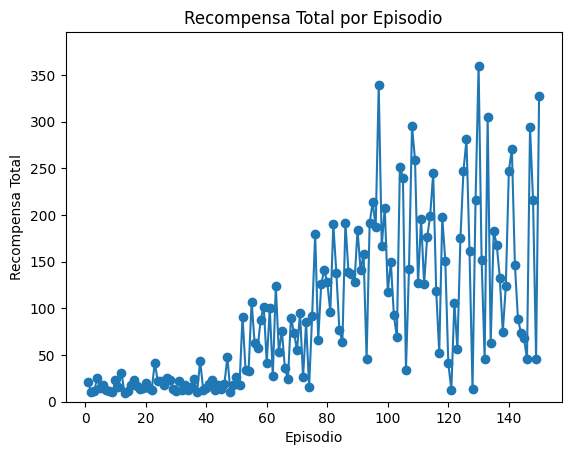

In [40]:
train_agent(env, agent, n_episodes=150, max_iterations=500, target_update_frequency=10)

In [41]:
agent.save("model2.keras")

In [42]:
test_agent(env, agent, episodes=5)

Prueba Episodio 1/5, Recompensa Total: 161.0
Prueba Episodio 2/5, Recompensa Total: 137.0
Prueba Episodio 3/5, Recompensa Total: 141.0
Prueba Episodio 4/5, Recompensa Total: 160.0
Prueba Episodio 5/5, Recompensa Total: 150.0
Recompensa promedio en 5 pruebas: 149.8


## Model 3

In [43]:
env = gym.make("CartPole-v1", render_mode=None)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [44]:
agent = DQLAgent(state_size, action_size, hyperparameters1, model2)

Episodio 1/150, Recompensa Total: 17.0, Epsilon: 1.00
Episodio 2/150, Recompensa Total: 13.0, Epsilon: 0.99
Episodio 3/150, Recompensa Total: 20.0, Epsilon: 0.99
Episodio 4/150, Recompensa Total: 27.0, Epsilon: 0.99
Episodio 5/150, Recompensa Total: 13.0, Epsilon: 0.98
Episodio 6/150, Recompensa Total: 13.0, Epsilon: 0.98
Episodio 7/150, Recompensa Total: 13.0, Epsilon: 0.97
Episodio 8/150, Recompensa Total: 34.0, Epsilon: 0.97
Episodio 9/150, Recompensa Total: 40.0, Epsilon: 0.96
Episodio 10/150, Recompensa Total: 38.0, Epsilon: 0.96
Episodio 11/150, Recompensa Total: 14.0, Epsilon: 0.95
Episodio 12/150, Recompensa Total: 48.0, Epsilon: 0.95
Episodio 13/150, Recompensa Total: 29.0, Epsilon: 0.94
Episodio 14/150, Recompensa Total: 14.0, Epsilon: 0.94
Episodio 15/150, Recompensa Total: 16.0, Epsilon: 0.93
Episodio 16/150, Recompensa Total: 30.0, Epsilon: 0.93
Episodio 17/150, Recompensa Total: 19.0, Epsilon: 0.92
Episodio 18/150, Recompensa Total: 20.0, Epsilon: 0.92
Episodio 19/150, Re

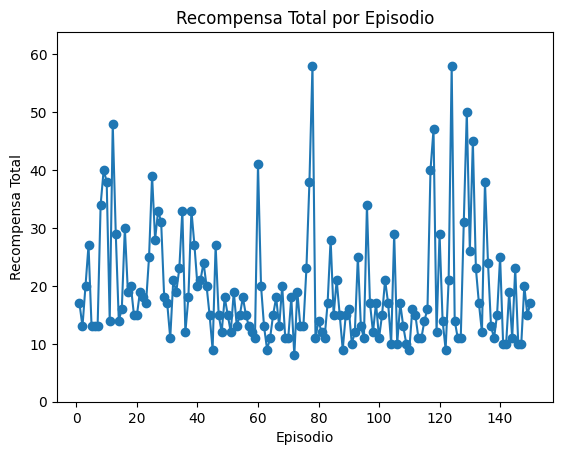

In [45]:
train_agent(env, agent, n_episodes=150, max_iterations=500, target_update_frequency=10)

In [46]:
agent.save("model3.keras")

In [47]:
test_agent(env, agent, episodes=5)

Prueba Episodio 1/5, Recompensa Total: 9.0
Prueba Episodio 2/5, Recompensa Total: 9.0
Prueba Episodio 3/5, Recompensa Total: 9.0
Prueba Episodio 4/5, Recompensa Total: 9.0
Prueba Episodio 5/5, Recompensa Total: 9.0
Recompensa promedio en 5 pruebas: 9.0


## Model 4

In [48]:
env = gym.make("CartPole-v1", render_mode=None)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [49]:
agent = DQLAgent(state_size, action_size, hyperparameters2, model2)

Episodio 1/150, Recompensa Total: 14.0, Epsilon: 1.00
Episodio 2/150, Recompensa Total: 16.0, Epsilon: 0.99
Episodio 3/150, Recompensa Total: 21.0, Epsilon: 0.98
Episodio 4/150, Recompensa Total: 22.0, Epsilon: 0.97
Episodio 5/150, Recompensa Total: 15.0, Epsilon: 0.96
Episodio 6/150, Recompensa Total: 23.0, Epsilon: 0.95
Episodio 7/150, Recompensa Total: 10.0, Epsilon: 0.94
Episodio 8/150, Recompensa Total: 14.0, Epsilon: 0.93
Episodio 9/150, Recompensa Total: 41.0, Epsilon: 0.92
Episodio 10/150, Recompensa Total: 16.0, Epsilon: 0.91
Episodio 11/150, Recompensa Total: 19.0, Epsilon: 0.90
Episodio 12/150, Recompensa Total: 18.0, Epsilon: 0.90
Episodio 13/150, Recompensa Total: 16.0, Epsilon: 0.89
Episodio 14/150, Recompensa Total: 16.0, Epsilon: 0.88
Episodio 15/150, Recompensa Total: 20.0, Epsilon: 0.87
Episodio 16/150, Recompensa Total: 27.0, Epsilon: 0.86
Episodio 17/150, Recompensa Total: 24.0, Epsilon: 0.85
Episodio 18/150, Recompensa Total: 15.0, Epsilon: 0.84
Episodio 19/150, Re

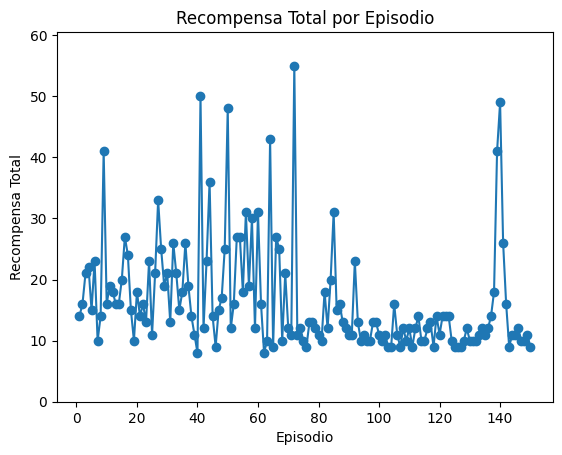

In [50]:
train_agent(env, agent, n_episodes=150, max_iterations=500, target_update_frequency=10)

In [51]:
agent.save("model4.keras")

In [52]:
test_agent(env, agent, episodes=5)

Prueba Episodio 1/5, Recompensa Total: 9.0
Prueba Episodio 2/5, Recompensa Total: 10.0
Prueba Episodio 3/5, Recompensa Total: 10.0
Prueba Episodio 4/5, Recompensa Total: 10.0
Prueba Episodio 5/5, Recompensa Total: 11.0
Recompensa promedio en 5 pruebas: 10.0


El segundo modelo realizado demostró ser el mejor por varias razones clave:
* Este modelo optimizó la estabilidad al incorporar una red de destino, lo que permitió mitigar las fluctuaciones en las actualizaciones de los pesos de la red principal. Además, se ajustaron los hiperparámetros de manera más precisa, lo que mejoró la capacidad del modelo para aprender patrones de manera eficiente y tomar mejores decisiones a lo largo del tiempo. 
* Este modelo alcanzó una mayor consistencia en el rendimiento, logrando equilibrar adecuadamente la exploración y la explotación, lo que resultó en una mayor puntuación acumulativa y un número sostenido de episodios en equilibrio antes de que el CartPole cayera.

# Task 2

### Proximal Policy Optimization
* Este consiste en un algoritmo de aprendizaje por refuerzo profundo que busca mejorar la eficiencia y estabilidad en el entrenamiento de agentes. Dicha técnica se basa en gradiente de políticas que optimiza una función objetivo diseñada para limitar las actualizaciones de la política, evitando cambios abruptos que puedan desestabilizar el aprendizaje. Esto se logra mediante el uso de una función de pérdida que incluye un término de recorte en la relación de probabilidad entre la política nueva y la antigua, asegurando que las actualizaciones sean "proximales" a la política actual.
* PPO puede ser utilizado para problemas que requieren un equilibrio entre eficiencia y estabilidad en el aprendizaje de políticas, tanto en espacios de acción continuos como discretos. Se utiliza en situaciones donde las actualizaciones de la política deben ser limitadas para evitar cambios abruptos que puedan desestabilizar el rendimiento del agente.


### Deep Deterministic Policy Gradients (DDPG)
* Este consiste en un algoritmo actor-crítico fuera de política (off-policy) diseñado para manejar espacios de acción continuos. DDPG utiliza una red actor que aprende una política determinista que mapea estados a acciones, y una red crítica que estima la función de valor Q. Para fomentar la exploración, introduce ruido en las acciones seleccionadas por el actor. 
* DDPG puede ser utilizado para problemas con espacios de acción continuos y de alta dimensionalidad, donde las decisiones del agente implican variables continuas en lugar de acciones discretas. Es adecuado para tareas que requieren una política determinista que mapee directamente estados a acciones específicas, permitiendo un control preciso y fino.


### Trust Region Policy Optimization (TRPO)
* Consiste en un algoritmo de gradiente de políticas que busca garantizar actualizaciones estables y confiables de la política. TRPO optimiza una función objetivo bajo la restricción de que la divergencia Kullback-Leibler (KL) entre la política nueva y la antigua no exceda un cierto límite. Esto define una "región de confianza" dentro de la cual la política puede actualizarse sin riesgo de grandes degradaciones en el rendimiento.
* TRPO puede ser utilizado para problemas que demandan actualizaciones de política estables y con garantías teóricas sobre el rendimiento. Se utiliza en entornos donde las políticas son sensibles a grandes cambios y donde es crucial mantener las actualizaciones dentro de una "región de confianza" para evitar degradaciones significativas en el desempeño.


### Asynchronous Advantage Actor-Critic (A3C)
* Consiste en un algoritmo que utiliza múltiples agentes que interactúan con copias independientes del entorno en paralelo y de manera asíncrona. Cada agente mantiene su propia versión de los parámetros de la red neuronal y actualiza una red global compartida. El término "Advantage" se refiere al uso de una estimación de ventaja para reducir la varianza en la actualización de los gradientes. 
* A3C puede ser utilizado para problemas que pueden beneficiarse de la paralelización y la asincronía para acelerar el proceso de aprendizaje. Es adecuado para tareas que involucran grandes espacios de estado y requieren decisiones en tiempo real, donde múltiples agentes pueden interactuar con el entorno de manera independiente y actualizar una política global compartida.


### Referencias
1. Tewari, U. (2021). Which Reinforcement learning-RL algorithm to use where, when and in what scenario? Medium. https://medium.datadriveninvestor.com/which-reinforcement-learning-rl-algorithm-to-use-where-when-and-in-what-scenario-e3e7617fb0b1